For topology optimization, we currently support Gaussian filters as a proof of concept. We will demonstrate that implementing a Gaussian filter in the optimization loop of topology optimization reduces performance degradation once the Gaussian filter is applied at the end to both geometries.

In [1]:
######## IMPORTS ########
# General purpose imports
import numpy as np
import os
import sys
import scipy as sp


sys.path.insert(0, ".")
from config import Config
sys.path.append(Config.LUMERICAL_API_PATH) # if this fails adjust the config.py and add the lumerical api path
root_path = Config.ROOT_DIR

# Optimization specific imports
from lumopt.geometries.topology import TopologyOptimization2D
from lumopt.utilities.load_lumerical_scripts import load_from_lsf
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimization import Optimization
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.utilities.wavelengths import Wavelengths
from lumopt_gl.utilities.lithography import LithographyOptimizer
from lumopt_gl.geometries.topology_gl import TopologyOptimizationGL_2D
from lumopt_gl.optimization import OptimizationGL # necessary for topology opt.


CONFIGURATION FILE {'root': 'C:\\Program Files/Lumerical/v232/api/python', 'lumapi': 'C:/Program Files/Lumerical/v232/api/python'}


In [2]:
def runSim(params, eps_min, eps_max, x_pos, y_pos, filter_R):

    ######## DEFINE A 2D TOPOLOGY OPTIMIZATION REGION ########
    geometry = TopologyOptimizationGL_2D(params=params, eps_min=eps_min, eps_max=eps_max, x=x_pos, y=y_pos, z=0, filter_R=filter_R)
    geometry.lithography_model = LithographyOptimizer(model='GaussianDUV')

    ######## DEFINE FIGURE OF MERIT ########
    # The base simulation script defines a field monitor named 'fom' at the point where we want to modematch to the fundamental TE mode
    fom = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental TE mode', direction = 'Forward', norm_p = 2, target_fom=0.5)

    ######## DEFINE OPTIMIZATION ALGORITHM ########
    optimizer = ScipyOptimizers(max_iter=50, method='L-BFGS-B', scaling_factor=1, pgtol=1e-6, ftol=1e-4, scale_initial_gradient_to=0.25)

    ######## LOAD TEMPLATE SCRIPT AND SUBSTITUTE PARAMETERS ########
    script = load_from_lsf(os.path.join(root_path, 'base_scripts/splitter_base_2D_TE_topology.lsf'))
	
    ## Here, we substitute the width of the optimization regio
    size_x = max(x_pos) - min(x_pos)
    script = script.replace('opt_size_x=3.5e-6','opt_size_x={:1.6g}'.format(size_x))
    
    wavelengths = Wavelengths(start = 1450e-9, stop = 1650e-9, points = 11)
    opt = OptimizationGL(base_script=script, wavelengths = wavelengths, fom=fom, geometry=geometry, optimizer=optimizer, use_deps=False, hide_fdtd_cad=False, plot_history=False, store_all_simulations=False)

    ######## RUN THE OPTIMIZER ########
    return opt

In [3]:

size_x = 3000		#< Length of the device (in nm). Longer devices typically lead to better performance
delta_x = 20		#< Size of a pixel along x-axis (in nm)

size_y = 1800		#< Since we use symmetry, this is only have the extent along the y-axis (in nm)
delta_y = 20		#< Size of a pixel along y-axis (in nm)

filter_R = 500		#< Radius of the smoothing filter which removes small features and sharp corners (in nm)

eps_max = 2.8**2	#< Effective permittivity for a Silicon waveguide with a thickness of 220nm
eps_min = 1.44**2	#< Permittivity of the SiO2 cladding

x_points=int(size_x/delta_x)+1
y_points=int(size_y/delta_y)+1

x_pos = np.linspace(-size_x/2,size_x/2,x_points)*1e-9
y_pos = np.linspace(0,size_y,y_points)*1e-9

## Set initial conditions
initial_cond = None                                #< Use the structure 'initial_guess' as defined in the project file      

opt = runSim(initial_cond, eps_min, eps_max, x_pos, y_pos, filter_R*1e-9)

Wavelength range of source object will be superseded by the global settings.
Making forward solve


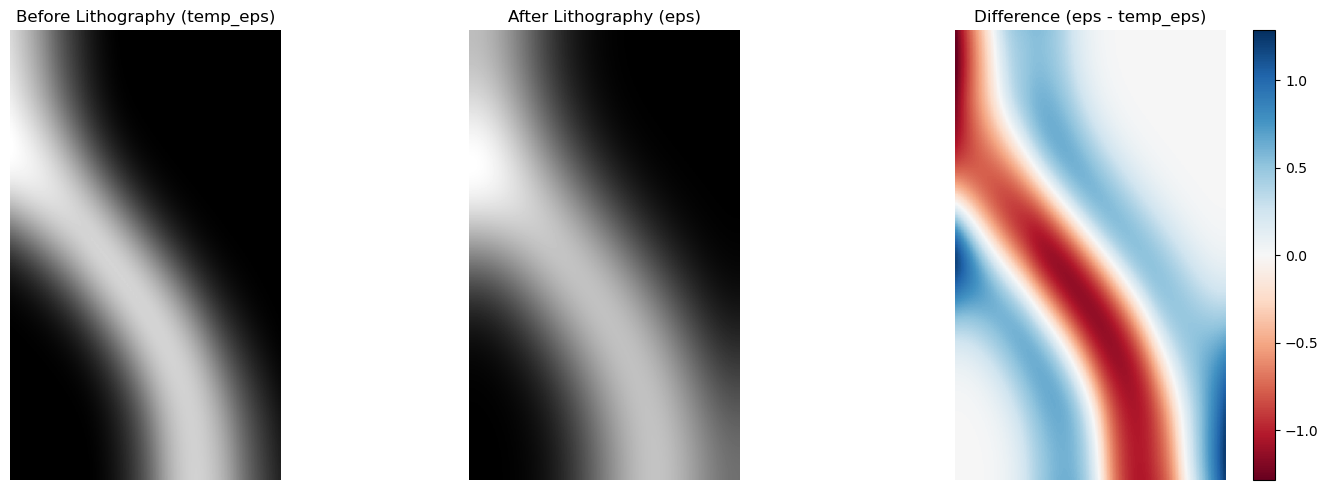

Making adjoint solve
[1. 1. 1. ... 0. 0. 0.]
Running solves
Processing forward solve
FOM = 0.4649073994363677 (0.5 - 0.03509260056363228)
Processing adjoint solve
Calculating gradients
Calculating Penalty Terms
Scaling factor is 863.8170661752397
Running scipy optimizer
bounds = [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
start = [1. 1. 1. ... 0. 0. 0.]


C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:19: MatplotlibDeprecationWarning: 
The 'clear_temp' parameter of setup() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'clear_temp', they should be passed as keyword, not positionally.
  super().setup(fig, dpi, frame_prefix, clear_temp = False)


Making forward solve


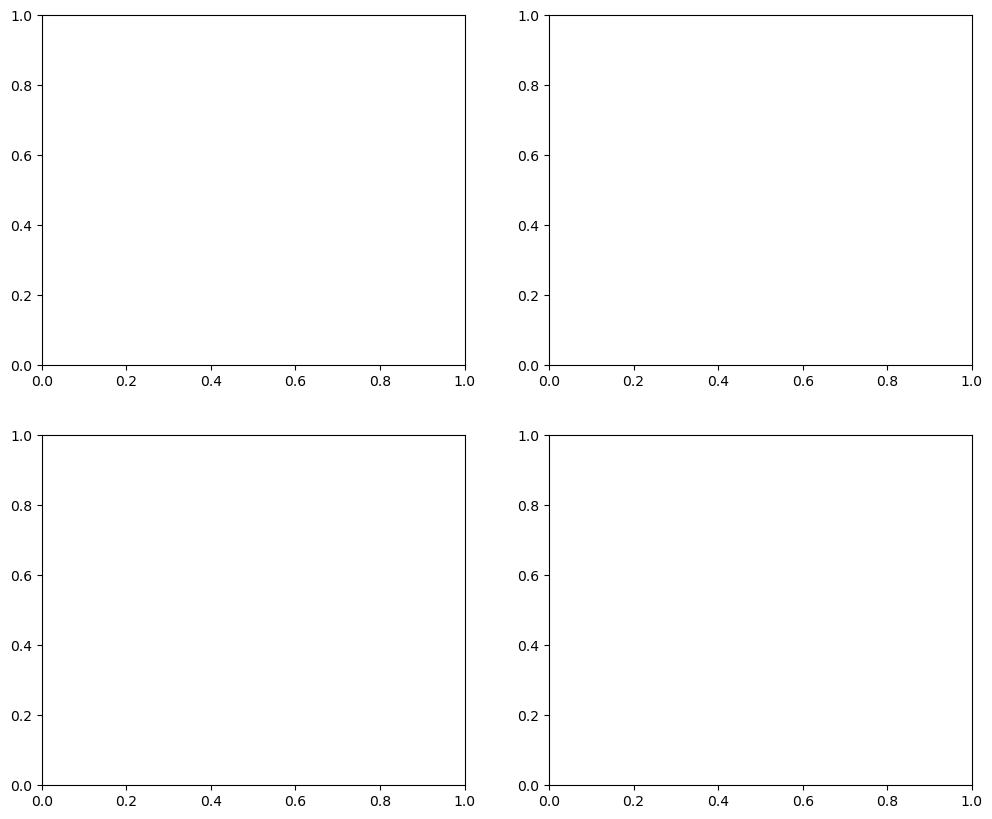

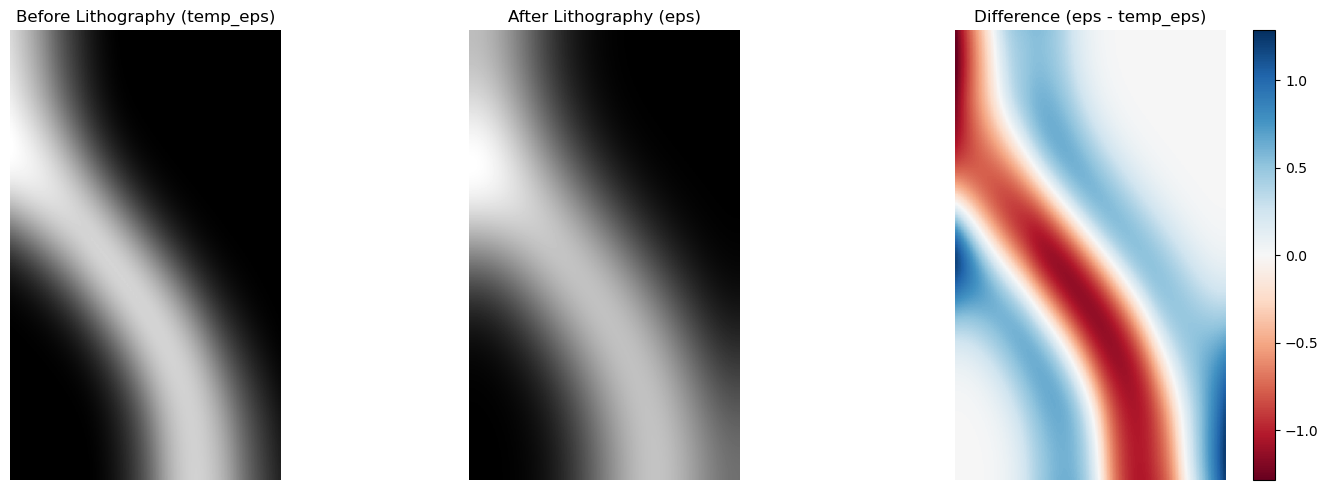

Making adjoint solve
[1. 1. 1. ... 0. 0. 0.]
Running solves
Processing forward solve
FOM = 0.4649073994363677 (0.5 - 0.03509260056363228)
Actual fom: 0.03509260056363228, Penalty term: 0, Total fom: 0.03509260056363228
Processing adjoint solve
Calculating gradients
Calculating Penalty Terms


C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:112: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))


Saved frame
Making forward solve


<Figure size 640x480 with 0 Axes>

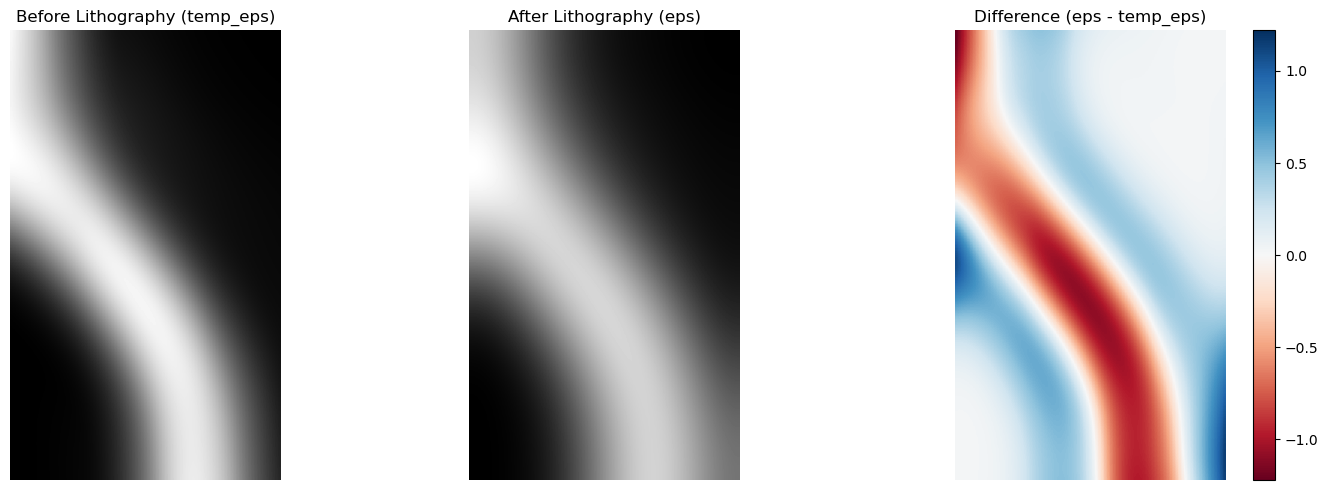

Making adjoint solve
[1. 1. 1. ... 0. 0. 0.]
Running solves
Processing forward solve
FOM = 0.4171865626822403 (0.5 - 0.0828134373177597)
Actual fom: 0.0828134373177597, Penalty term: 0, Total fom: 0.0828134373177597
Processing adjoint solve


In [4]:
opt.run()

In [ ]:
eps = opt.geometry.eps

In [ ]:
opt.geometry.lithography_model = LithographyOptimizer(model = 'GaussianDUV')

In [ ]:
opt.run_forward_simulation_topology(eps)

In [ ]:
opt = runSim(initial_cond, eps_min, eps_max, x_pos, y_pos, filter_R*1e-9)
opt.geometry.lithography_model = LithographyOptimizer(model = 'GaussianDUV')
opt.run()

Now to visualize what its doing

In [ ]:
import numpy as np

# Path to the .npz file
file_path = rf'C:\Users\shahe\Documents\GitHub\Lumopt_GL\notebooks\lithography\parameters_743.npz'

# Load the npz file
data = np.load(file_path)

# data is a Numpy object acting like a dictionary
print("Arrays in this file:")
for key in data:
    print(key)

# Access a specific array
array_data = data['params']
eps_data = data['eps']
beta = data['beta']
print(beta)

# Make sure to close the file after you are done
data.close()

In [ ]:

import matplotlib.pyplot as plt

# Create a heatmap using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(eps_data, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to a plot
plt.title('Heatmap of Matrix Data')
plt.show()

In [ ]:
eps_data.max()

In [ ]:
opt.initialize()

In [ ]:
opt.run_forward_simulation_topology(eps_data)

In [ ]:
from scipy.ndimage import gaussian_filter
filtered_eps = gaussian_filter(eps_data, sigma=3)

In [ ]:
filtered_eps.max()

In [ ]:

import matplotlib.pyplot as plt

# Create a heatmap using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(filtered_eps, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to a plot
plt.title('Heatmap of Matrix Data')
plt.show()

In [ ]:
opt.run_forward_simulation_topology(filtered_eps)

In [ ]:
import numpy as np

# Assuming filtered_eps is already defined
# Get the min and max values from the array
min_value = np.min(filtered_eps)
max_value = np.max(filtered_eps)

# Calculate the midpoint between min and max
midpoint = (min_value + max_value) / 2

# Binarize the array: values above the midpoint are set to max_value, below are set to min_value
binarized_eps = np.where(filtered_eps >= midpoint, max_value, min_value)

print(binarized_eps)


In [ ]:

import matplotlib.pyplot as plt

# Create a heatmap using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(binarized_eps, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to a plot
plt.title('Heatmap of Matrix Data')
plt.show()

In [ ]:
opt.run_forward_simulation_topology(binarized_eps)